In [1]:
# stdlib
import math, sys, importlib
    
# packages
import numpy as np
from numpy import sqrt, pi
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from scipy.integrate import quad, odeint
import scipy.constants as c

# local modules
import config
model = config.Model()
import g_star
from util import *

In [2]:
def test_interpolator(interpolator):
    g_rho_interp = interpolator(g_star.T, g_star.g_rho)
    g_s_interp = interpolator(g_star.T, g_star.g_s)
    #plt.figure(figsize=(10, 5))
    N = 400
    T = np.logspace(np.log10(np.min(g_star.T)), np.log10(np.max(g_star.T)), N)
    
    plt.semilogx(T, g_rho_interp(T), "-b", label=r"$g_\rho$ Interpolated")
    plt.semilogx(T, g_s_interp(T), "--r", label=r"$g_\rho$ Interpolated")
    
    plt.semilogx(g_star.T, g_star.g_rho, "*b", label=r"$g_\rho$ Data")
    plt.semilogx(g_star.T, g_star.g_s, "+r", label=r"$g_s$ Data")

    plt.legend()
    plt.grid()
    plt.xlabel("T / eV")
    plt.ylabel("g")
    
    return g_rho_interp, g_s_interp

(<scipy.interpolate._cubic.CubicSpline at 0x7f82da4c7938>,
 <scipy.interpolate._cubic.CubicSpline at 0x7f82da4c7990>)

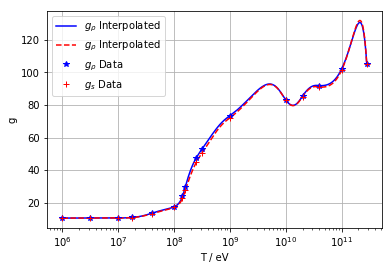

In [3]:
test_interpolator(interp.CubicSpline) # too many bumps

(<scipy.interpolate.interpolate.interp1d at 0x7f82d82766d8>,
 <scipy.interpolate.interpolate.interp1d at 0x7f82d82763b8>)

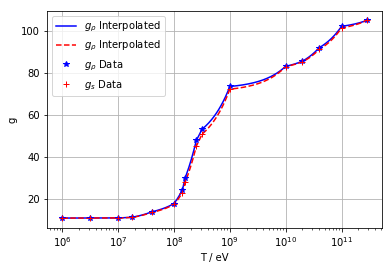

In [4]:
test_interpolator(interp.interp1d) # no derivative

(<scipy.interpolate._cubic.Akima1DInterpolator at 0x7f82d821cf10>,
 <scipy.interpolate._cubic.Akima1DInterpolator at 0x7f82d821cfc0>)

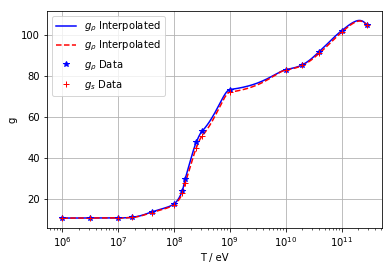

In [5]:
test_interpolator(interp.Akima1DInterpolator) # ok, little bump at the end

/usr/local/lib/python3.6/dist-packages/scipy/interpolate/polyint.py:609: RuntimeWarning: divide by zero encountered in true_divide
  p = np.dot(c,self.yi)/np.sum(c,axis=-1)[...,np.newaxis]


(<scipy.interpolate.polyint.BarycentricInterpolator at 0x7f82d80b1098>,
 <scipy.interpolate.polyint.BarycentricInterpolator at 0x7f82d80b1db8>)

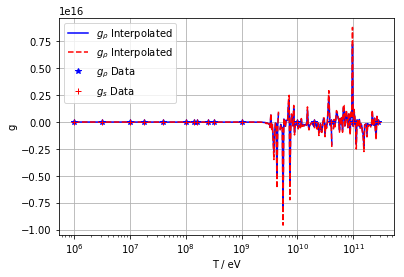

In [6]:
test_interpolator(interp.BarycentricInterpolator) # oh

(<scipy.interpolate.polyint.KroghInterpolator at 0x7f82d8215a98>,
 <scipy.interpolate.polyint.KroghInterpolator at 0x7f82d82151d8>)

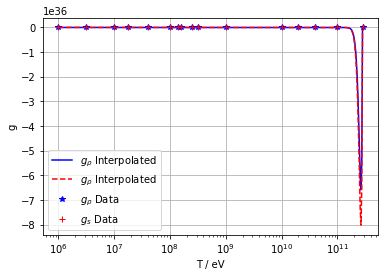

In [7]:
test_interpolator(interp.KroghInterpolator) # ooooh

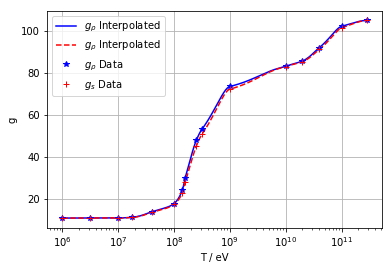

In [8]:
# ok, this one also uses cubic splines but only monotonic ones, therefore there are no bunmps
test_interpolator(interp.PchipInterpolator) 
plt.savefig("Plots/g_plot.pdf")

In [9]:
# float(g_rho_interp.derivative()(1e9)) # how to get the derivative



$$
 \frac{\mathrm{d} t}{\mathrm{d} T}  = - M_\mathrm{pl} \sqrt{\frac{45}{64 \pi^3}} \frac{1}{T^3 g_s(T) \sqrt{g_\rho(T)}} (T g_\rho'(T) + 4 g_\rho(T))
$$

$$
\Rightarrow t(T) = t_0 + \int^T_{T(t = t_0)} \frac{\mathrm{d} t}{\mathrm{d} T} \mathrm{d} T
$$

$$
\frac{\mathrm{d} t}{\mathrm{d} T} \sim \frac{ 14 \cdot 10^{9} \mathrm{yr} }{ 10^{12} \mathrm{K} }
$$

In [11]:
def dtdT(T):
    return (
        # this is in 1/eV / eV = eV^-2
        - model.M_pl * sqrt(45 / (64 * pi**3)) * 
        1 / (T**3 * g_star.g_s_interp(T) * sqrt(g_star.g_rho_interp(T))) *
        (T*g_star.g_rho_interp_diff(T) + 4*g_star.g_rho_interp(T))
    )

ans = t, t_err = quad(dtdT, 100e6, 100e3) 

np.array(ans) / c.elementary_charge * c.hbar

array([  1.48051968e+01,   1.89173419e-07])

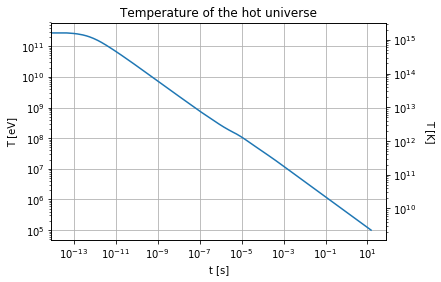

In [12]:
T = np.logspace(5, np.log10(np.max(g_star.T)), 400)[::-1]
# T = np.linspace(100e6, 100e3, 300)
t0 = 0 # 1e-13 * c.sc.elementary_charge / c.sc.hbar

t = odeint(lambda t, T: dtdT(T), t0, T)

T_in_K = T * c.elementary_charge / c.Boltzmann 
t_in_s = t / c.elementary_charge * c.hbar

fig, ax1 = plt.subplots()
ax1.loglog(t_in_s, T)
ax2 = ax1.twinx()
ax1.set_ylabel("T [eV]")
ax1.set_xlabel("t [s]")
ax2.set_ylabel("T [K]", rotation=-90, labelpad=18)
ax2.set_ylim(np.min(T_in_K), np.max(T_in_K))
ax2.set_yscale("log")
ax1.grid()
ax1.set_title("Temperature of the hot universe")
plt.savefig("Plots/T_of_t_plot.pdf")